<a href="https://colab.research.google.com/github/seanrjohnson/esmologs/blob/main/notebooks/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensitive remote homology search by local alignment of small positional embeddings from protein language models


## Data analysis code

This notebook downloads search results from Zenodo and creates the figure and summary tables from the manuscript

In [3]:
#@title Import dependencies

import pandas as pd
import os # accessing directory structure
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def read_seq_search_triple(file, dataset_name, seq_to_family, seq_to_clan, seq_to_pid_bin):
    df = pd.read_table(file, sep="\t",index_col=None, header=None, names=['query_seq','target_seq','score'])
    # keep only max score for each query
    df = df.loc[df.groupby('query_seq')['score'].idxmax()].copy()


    df["dataset"] = dataset_name

    df['query_family'] = df['query_seq'].map(lambda x: seq_to_family[x])
    df['target_family'] = df['target_seq'].map(lambda x: seq_to_family[x])
    df['query_clan'] = df['query_seq'].map(lambda x: seq_to_clan[x])
    df['target_clan'] = df['target_seq'].map(lambda x: seq_to_clan[x])
    df['pid_bin'] = df['query_seq'].map(lambda x: seq_to_pid_bin[x])
    return df

def read_profile_search_triple(file, dataset_name, seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin):
    df = pd.read_table(file, sep="\t",index_col=None, header=None, names=['query_seq','target_family','score'])
    # keep only max score for each query
    df = df.loc[df.groupby('query_seq')['score'].idxmax()].copy()

    df["dataset"] = dataset_name

    df['query_family'] = df['query_seq'].map(lambda x: seq_to_family[x])
    df['query_clan'] = df['query_seq'].map(lambda x: seq_to_clan[x])

    df["target_clan"] = df["target_family"].map(lambda x: family_to_clan[x])
    df['pid_bin'] = df['query_seq'].map(lambda x: seq_to_pid_bin[x])
    return df


def get_pid_bin(acc, acc_bins=((0,12),(12,14),(14,16),(16,18),(18,20),(20,22),(22,24),(24,26),(26,100))):
    for i, (min_acc, max_acc) in enumerate(acc_bins):
        if acc >= min_acc and acc < max_acc:
            return f"{min_acc}-{max_acc}"
    raise ValueError("pid {} not in any bin".format(acc))

In [9]:
#@title Download and extract data

!wget https://zenodo.org/record/8174960/files/search_results.tar.gz
!wget https://zenodo.org/record/8174960/files/pfamN_family_clans.tsv
!wget https://zenodo.org/record/8174960/files/pfamN_pids.tsv
!tar -xf search_results.tar.gz

--2023-07-27 10:30:28--  https://zenodo.org/record/8174960/files/pfamN_family_clans.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55505160 (53M) [application/octet-stream]
Saving to: ‘pfamN_family_clans.tsv’

pfamN_family_clans. 100%[===================>]  52.93M  4.10MB/s    in 57s     

2023-07-27 10:31:26 (950 KB/s) - ‘pfamN_family_clans.tsv’ saved [55505160/55505160]

--2023-07-27 10:31:26--  https://zenodo.org/record/8174960/files/pfamN_pids.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1539779 (1.5M) [application/octet-stream]
Saving to: ‘pfamN_pids.tsv’

pfamN_pids.tsv      100%[===================>]   1.47M   639KB/s    in 2.4s    

2023-07-27 10:31:31 (639 KB/s) - ‘pfamN_pids.tsv’ saved [1539779/1539779]



In [13]:
#@title Load datasets
clans_data=pd.read_table("pfamN_family_clans.tsv", index_col=0)
seq_to_clan = clans_data["clan"].to_dict()

pid_data = pd.read_csv('pfamN_pids.tsv', sep="\t", index_col=0)
pid_data["clan"] = pid_data.index.map(lambda x: seq_to_clan[x])
pid_data["pid_bin"] = pid_data["max_pid"].map(get_pid_bin)
family_pid_bin_sizes = pid_data.groupby("pid_bin").count()["family"].to_dict()
clan_pid_bin_sizes = pid_data.dropna(subset=["clan"]).groupby("pid_bin").count()["family"].to_dict()

seq_to_family = clans_data["family_id"].to_dict()

seq_to_pid_bin = pid_data["pid_bin"].to_dict()
family_to_clan = clans_data.set_index("family_id")["clan"].to_dict()

datasets = [
           read_profile_search_triple("search_results/1_test_hits_hmmscan.tsv","1. hmmscan, aa seq, aa hmmer profile",seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           read_seq_search_triple("search_results/2_test_hits_phmmer.tsv", "2. phmmer, aa seq, aa seq",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/3_test_esm2_3B_msas_pnone_hmmsearch.tsv", "3. hmmsearch, pred hmmer profile, aa seq",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/4_test_esm2_3B_msas_hmmsearch.tsv", "4. hmmsearch, pred hmmer profile dchlet, aa seq",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_profile_search_triple("search_results/5_test_hits_hhblits_esm2_3B_test_pep_aligned_train.tsv", "5. hhblits, pred hhsuite profile, aa hhsuite profile",seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           read_seq_search_triple("search_results/6_test_hits_hhblits_esm2_3B_test_esm2_3B_train.tsv", "6. hhblits, pred hhsuite profile, pred hhsuite profile",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/7_test_train_3Di_pred_foldseek.tsv", "7. foldseek, pred 3Di, pred 3Di",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/8_test_train_3Di_pred_foldseek_3Di_only.tsv", "8. foldseek 3Di-only, pred 3Di, pred 3Di",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_profile_search_triple("search_results/9_test_3Di_pred_3Di_aahmmscan.tsv", "9. hmmscan, pred 3Di, pred 3Di hmmer profile", seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           read_profile_search_triple("search_results/10_test_3Di_pred_3Di_hmmscan.tsv", "10. 3Di_hmmscan, pred 3Di, pred 3Di hmmer3Di profile", seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           ]
hue_order = [df.iloc[0]["dataset"] for df in datasets]
datasets_combined = pd.concat(datasets, ignore_index=True)
datasets_combined["correct_family"] = datasets_combined["query_family"] == datasets_combined["target_family"]
datasets_combined["correct_clan"] = datasets_combined["query_clan"] == datasets_combined["target_clan"]


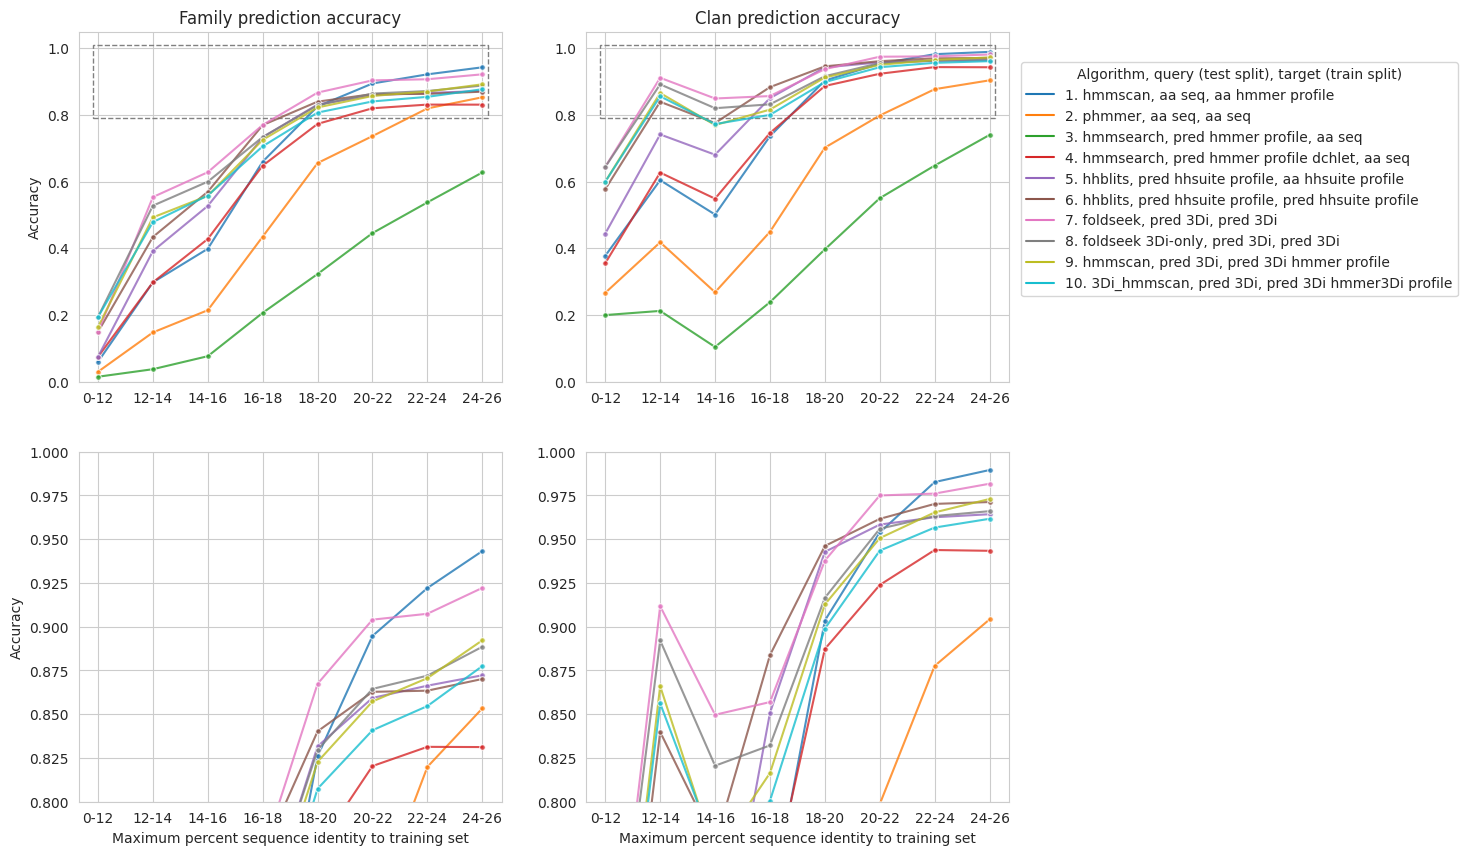

In [33]:
#@title Draw graph

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)

hue_order = [df.iloc[0]["dataset"] for df in datasets]

family_accuracies = {"dataset":[], "pid_bin":[], "accuracy":[]}
for (dataset, pid_bin), group in datasets_combined.groupby(["dataset","pid_bin"]):
    count = len(group)
    #correct = len(group[group["query_family"] == group["target_family"]])
    correct = sum(group["correct_family"])
    family_accuracies["dataset"].append(dataset)
    family_accuracies["pid_bin"].append(pid_bin)
    family_accuracies["accuracy"].append(correct/family_pid_bin_sizes[pid_bin])
family_accuracies = pd.DataFrame(family_accuracies)

clan_accuracies = {"dataset":[], "pid_bin":[], "accuracy":[]}

for (dataset, pid_bin), group in datasets_combined.dropna(subset=["query_clan"]).groupby(["dataset","pid_bin"]):
    count = len(group)
    # correct = len(group[group["query_clan"] == group["target_clan"]])
    correct = sum(group["correct_clan"])
    clan_accuracies["dataset"].append(dataset)
    clan_accuracies["pid_bin"].append(pid_bin)
    clan_accuracies["accuracy"].append(correct/clan_pid_bin_sizes[pid_bin])
group_accuracies = pd.DataFrame(clan_accuracies)

ax = sns.lineplot(x="pid_bin", y="accuracy", hue='dataset', marker="o", markersize=4, linewidth=1.5, data=family_accuracies, hue_order=hue_order, alpha=0.8, ax=axes[0,0], legend=False)
ax.set_ylim([0, 1.05])
#ax.set_xlabel("Maximum percent sequence identity to training set")
ax.set_ylabel("Accuracy")
ax.set_title("Family prediction accuracy")
ax.set_xlabel(None)
rect = Rectangle((-0.1,0.79), 7.2, 0.22, angle=0, linestyle = 'dashed', facecolor = 'None', edgecolor="grey", clip_on=False)
ax.add_patch(rect)

ax = sns.lineplot(x="pid_bin", y="accuracy", hue='dataset', marker="o", markersize=4, linewidth=1.5, data=family_accuracies, hue_order=hue_order, alpha=0.8, ax=axes[1,0], legend=False)
ax.set_ylim([0.8, 1])
ax.set_xlabel("Maximum percent sequence identity to training set")
ax.set_ylabel("Accuracy")
#ax.set_title("Family prediction accuracy")


sns.set_style("whitegrid")
#plt.figure(figsize=(8,15))
ax = sns.lineplot(x="pid_bin", y="accuracy", hue='dataset', marker="o", markersize=4, linewidth=1.5, data=clan_accuracies, hue_order=hue_order, alpha=0.8, ax=axes[0,1], legend=False)
ax.set_ylim([0, 1.05])
#ax.set_xlabel("Maximum percent sequence identity to training set")
ax.set_ylabel("")
ax.set_xlabel(None)
ax.set_title("Clan prediction accuracy")
rect = Rectangle((-0.1,0.79), 7.2, 0.22, angle=0, linestyle = 'dashed', facecolor = 'None', edgecolor="grey", clip_on=False)
ax.add_patch(rect)

ax = sns.lineplot(x="pid_bin", y="accuracy", hue='dataset', marker="o", markersize=4, linewidth=1.5, data=clan_accuracies, hue_order=hue_order, alpha=0.8, ax=axes[1,1])
ax.set_ylim([0.8, 1])
ax.set_xlabel("Maximum percent sequence identity to training set")
ax.set_ylabel("")
#ax.set_title("Clan prediction accuracy")
ax.get_legend().remove()
fig.legend(bbox_to_anchor=(0.91, 0.85), loc=2, borderaxespad=0., fontsize=10, title="Algorithm, query (test split), target (train split)")
#fig.savefig("accuracy_vs_pid_bin.png", bbox_inches='tight', dpi=300)
fig.show()


In [22]:
#@title summary statistics
print(family_pid_bin_sizes)

print(clan_pid_bin_sizes)
num_clans = sum(clan_pid_bin_sizes.values())
num_families = sum(family_pid_bin_sizes.values())

print(f"num_families: {num_families}\n")
print(f"num_clans: {num_clans}\n")

print("Correct family percent")
print(100-(100 * datasets_combined.groupby(["dataset"])["correct_family"].sum() / num_families))
print("\nTotal correct families")
print( num_families - datasets_combined.groupby(["dataset"])["correct_family"].sum())

print("Correct clan percent")
print(100-(100 * datasets_combined.dropna(subset=["query_clan"]).groupby(["dataset"])["correct_clan"].sum() / num_clans))
print("\nTotal correct clans")
print(num_clans - datasets_combined.dropna(subset=["query_clan"]).groupby(["dataset"])["correct_clan"].sum())


{'0-12': 67, '12-14': 426, '14-16': 1058, '16-18': 2516, '18-20': 4419, '20-22': 6013, '22-24': 4892, '24-26': 1902}
{'0-12': 45, '12-14': 306, '14-16': 652, '16-18': 1454, '18-20': 2395, '20-22': 3362, '22-24': 2884, '24-26': 1148}
num_families: 21293

num_clans: 12246

Correct family percent
dataset
1. hmmscan, aa seq, aa hmmer profile                      17.583243
10. 3Di_hmmscan, pred 3Di, pred 3Di hmmer3Di profile      19.884469
2. phmmer, aa seq, aa seq                                 32.602264
3. hmmsearch, pred hmmer profile, aa seq                  59.831870
4. hmmsearch, pred hmmer profile dchlet, aa seq           23.848213
5. hhblits, pred hhsuite profile, aa hhsuite profile      18.686892
6. hhblits, pred hhsuite profile, pred hhsuite profile    17.742920
7. foldseek, pred 3Di, pred 3Di                           14.004602
8. foldseek 3Di-only, pred 3Di, pred 3Di                  17.625511
9. hmmscan, pred 3Di, pred 3Di hmmer profile              18.358146
Name: correct_fam